In [41]:
from pyhdf.SD import SD, SDC, SDS
from pyhdf.HDF import *
from pyhdf.VS import *
import pyart
import glob
import xarray
from scipy import interpolate
from dask import bag as db
from netCDF4 import Dataset
from scipy import ndimage
from matplotlib.collections import LineCollection
from datetime import datetime, timedelta
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipython-6.5.0-py3.6.egg/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
file_path = '/lcrc/group/earthscience/rjackson/cloudsat/2007063042216_04512_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf'
cpol_file_path = '/lcrc/group/earthscience/rjackson/echo_tops/echo_tops_70km_1000m/2007/20070304/echo_tops_200703040500.cdf'

In [5]:
f = HDF(path=file_path, mode=SDC.READ)
vs = f.vstart()
vdata_lat = vs.attach('Latitude')
vdata_long = vs.attach('Longitude')
time = vs.attach('Profile_time')
UTC_start = vs.attach('UTC_start')
TAI_start = vs.attach('TAI_start')
cpr_echo_top = vs.attach('CPR_Echo_Top')
lat = np.array(vdata_lat[:])
lon = np.array(vdata_long[:])
time = time[:]
cpr_echo_top = cpr_echo_top[:]
TAI_start = TAI_start[:]
UTC_start = UTC_start[:]
data_info_list = vs.vdatainfo()

vs.end() # terminate the vdata interface
f.close()


HDF4Error: close (42): There are still active AIDs

In [ ]:
dset = SD(path=file_path, mode=SDC.READ)
datasets_dic = dset.datasets()
print(dset.datasets())
ref = dset.select('Radar_Reflectivity')
mask = dset.select('CPR_Cloud_mask')
mask = mask.get()
height = dset.select('Height')
height = height.get()
attr_dict = ref.attributes()
ref_array = ref.get()
min_valid = attr_dict['valid_range'][0]
max_valid = attr_dict['valid_range'][1]
ref_array = np.ma.masked_where(np.logical_or.reduce((ref_array <= min_valid, ref_array >= max_valid, mask < 25)), ref_array)

In [ ]:
print(lat.shape)
print(dset.datasets().keys())

In [ ]:
array_shape = height.shape
#cloud_top = np.zeros(array_shape[0])
y_values, x_values = np.meshgrid(range(0, array_shape[0]), range(0, array_shape[1]), indexing='ij')
labels = y_values

height_masked = np.ma.masked_where(ref_array.mask == True, height)
cloud_top = np.ma.max(height_masked, axis=1, fill_value=-9999.0)
print(cloud_top)
any_cloud = np.any(mask > 25, axis=1)
last_cloud = mask[:,-1] > 25
geographical_region = np.squeeze(np.logical_and.reduce((lat > -13.25, lat < -11.25, lon > 130, lon < 132)))
print(np.logical_or(any_cloud == False, geographical_region.T == False))
#cloud_top = np.ma.masked_where(np.logical_or(any_cloud == False, geographical_region == False), cloud_top)
plt.plot(cloud_top)

In [ ]:
new_ref = ref_array[~np.logical_or(any_cloud == False, geographical_region == False), :].T/100.0
new_h = height[~np.logical_or(any_cloud == False, geographical_region == False), :].T
new_lon = lon[~np.logical_or(any_cloud == False, geographical_region == False)]
new_lat = lon[~np.logical_or(any_cloud == False, geographical_region == False)]
new_ctop = cloud_top[~np.logical_or(any_cloud == False, geographical_region == False)]
lon_tile = np.tile(new_lon, [1, new_ref.shape[0]])
plt.pcolormesh(lon_tile.T, new_h, new_ref, cmap='pyart_HomeyerRainbow')
plt.plot(new_lon, new_ctop, linewidth=3, color='k')
plt.colorbar(label='Reflectivity')

In [ ]:
print(int(TAI_start[0][0]))
python_times = timedelta(seconds=int(TAI_start[0][0])) + np.array([datetime.datetime(1993,1,1) +timedelta(seconds=x[0]) for x in time])
print(python_times[~np.logical_or(any_cloud == False, geographical_region == False)])

In [ ]:
echo_top_dset = Dataset(cpol_file_path)
lat_echo = echo_top_dset.variables['lat'][:,:]
lon_echo = echo_top_dset.variables['lon'][:,:]
eth = echo_top_dset.variables['ETH'][:,:]

lat1d = lat_echo[:,1]
lon1d = lon_echo[1,:]
eth_cpol = np.zeros(new_ctop.shape)
for i in range(len(new_lon)):
    j_ind = np.argmin(np.abs(new_lon[i]-lon1d))
    i_ind = np.argmin(np.abs(new_lat[i]-lat1d))
    eth_cpol[i] = eth[i_ind, j_ind]
cloud_sat_data_mask = ~np.logical_or(any_cloud == False, geographical_region == False)
plt.pcolormesh(lon_echo, lat_echo, eth)
plt.colorbar(label='ETH [m]')
plt.scatter(lon[cloud_sat_data_mask], lat[cloud_sat_data_mask])

In [ ]:
plt.scatter(eth_cpol/1e3, new_ctop/1e3)
plt.ylabel('CloudSat ETH [km]')
plt.xlabel('CPOL ETH [km]')
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.plot([0, 20], [0, 20], color='k')

In [75]:
def get_eth_cloudsat_and_cpol(file):
    #try:
    f = HDF(path=file, mode=SDC.READ)
    vs = f.vstart()
    vdata_lat = vs.attach('Latitude')
    vdata_long = vs.attach('Longitude')
    time = vs.attach('Profile_time')
    UTC_start = vs.attach('UTC_start')
    TAI_start = vs.attach('TAI_start')
    lat = np.array(vdata_lat[:])
    lon = np.array(vdata_long[:])
    time = time[:]
    TAI_start = TAI_start[:]
    UTC_start = UTC_start[:]
    data_info_list = vs.vdatainfo()
        

    vs.end() # terminate the vdata interface
    #f.close()
    #except:
    #    return [], []
    # Load SDS datasets
    dset = SD(path=file, mode=SDC.READ)
    datasets_dic = dset.datasets()
    ref = dset.select('Radar_Reflectivity')
    mask = dset.select('CPR_Cloud_mask')
    mask = mask.get()
    height = dset.select('Height')
    height = height.get()
    attr_dict = ref.attributes()
    ref_array = ref.get()
    min_valid = -5000.0
    max_valid = 6000.0
    ref_array = np.ma.masked_where(np.logical_or.reduce((ref_array <= min_valid, ref_array >= max_valid, mask < 25)), ref_array)
    
    # Get cloud top heights assuming "good echoes"
    array_shape = height.shape
    #cloud_top = np.zeros(array_shape[0])
    y_values, x_values = np.meshgrid(range(0, array_shape[0]), range(0, array_shape[1]), indexing='ij')
    labels = y_values

    height_masked = np.ma.masked_where(ref_array.mask == True, height)
    cloud_top = np.ma.max(height_masked, axis=1, fill_value=-9999.0)

    any_cloud = np.any(mask > 25, axis=1)
    last_cloud = mask[:,-1] > 25
    geographical_region = np.squeeze(np.logical_and.reduce((lat > -13.25, lat < -11.25, lon > 130, lon < 132)))

    new_ref = ref_array[~np.logical_or(any_cloud == False, geographical_region == False), :].T/100.0
    new_h = height[~np.logical_or(any_cloud == False, geographical_region == False), :].T
    new_lon = lon[~np.logical_or(any_cloud == False, geographical_region == False)]
    new_lat = lon[~np.logical_or(any_cloud == False, geographical_region == False)]
    new_ctop = cloud_top[~np.logical_or(any_cloud == False, geographical_region == False)]
    
    # Now we get the closest CPOL scan
    python_times = timedelta(seconds=int(TAI_start[0][0])) + np.array([datetime.datetime(1993,1,1) +timedelta(seconds=x[0]) for x in time])
    try:
        the_time = python_times[~np.logical_or(any_cloud == False, geographical_region == False)][0]
    except IndexError:
        return np.ma.array(np.nan), np.ma.array(np.nan)
    
    year = '%4d' % the_time.year
    month = '%02d' % the_time.month
    day = '%02d' % the_time.day
    hour = '%02d' % the_time.hour
    minute = '%02d' % the_time.minute
    print(the_time)
    
    cpol_eth_file = ('/lcrc/group/earthscience/rjackson/echo_tops/echo_tops_70km_1000m_ref/' + 
                     year + '/' + year + month + day + '/' + 'echo_tops_' + year + month + 
                     day + hour + minute[0] + '0.cdf')
    echo_top_dset = Dataset(cpol_file_path)
    lat_echo = echo_top_dset.variables['lat'][:,:]
    lon_echo = echo_top_dset.variables['lon'][:,:]
    eth = echo_top_dset.variables['ETH'][:,:]

    lat1d = lat_echo[:,1]
    lon1d = lon_echo[1,:]
    eth_cpol = np.zeros(new_ctop.shape)
    for i in range(len(new_lon)):
        j_ind = np.argmin(np.abs(new_lon[i]-lon1d))
        i_ind = np.argmin(np.abs(new_lat[i]-lat1d))
        eth_cpol[i] = eth[i_ind, j_ind]
    return new_ctop, eth_cpol


Loading /lcrc/group/earthscience/rjackson/cloudsat/2016008042414_51583_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
2016-01-08 05:10:14.040039


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Warning: converting a masked element to nan.


Loading /lcrc/group/earthscience/rjackson/cloudsat/2009340042434_19191_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
2009-12-06 05:10:59.718994
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015365164548_51474_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010031164552_20014_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2007014164932_03806_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
2007-01-14 16:52:44.240005
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012075164306_31289_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015125164643_47979_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015085042448_47389_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
2015-03-26 05:10:47.800049
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010343042216_24550_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
2010-12-09 05:08:15.159912
Loading /lcrc/group/earthscience/rja

2007-01-31 05:07:55.159912
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010096041747_20953_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2007071164356_04636_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2013360041813_40763_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2014354042438_45991_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
2014-12-20 05:10:45.838989
Loading /lcrc/group/earthscience/rjackson/cloudsat/2006172042034_00784_CS_2B-GEOPROF_GRANULE_P_R04_E00.hdf
2006-06-21 05:06:46.879883
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012030165000_30633_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012365042405_35506_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
2012-12-30 05:10:13
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010054165201_20349_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
2010-02-23 16:55:14.240005
Loading /lcrc/gr

Loading /lcrc/group/earthscience/rjackson/cloudsat/2013056041833_36336_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2013359164602_40756_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015052165247_46916_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2016064164600_52406_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2013040041823_36103_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012019041628_30465_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2007008041536_03711_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2006309041529_02779_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015062041845_47054_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjac

Loading /lcrc/group/earthscience/rjackson/cloudsat/2012121164805_31960_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2011345164528_29904_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012050042046_30917_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
2012-02-19 05:06:43.078979
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010103042353_21055_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
2010-04-13 05:09:51.519043
Loading /lcrc/group/earthscience/rjackson/cloudsat/2014090164627_42154_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2014011041810_40996_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015094041839_47520_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2016039165159_52042_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010342165004_24543_CS_2B-GEOPROF_GRANU

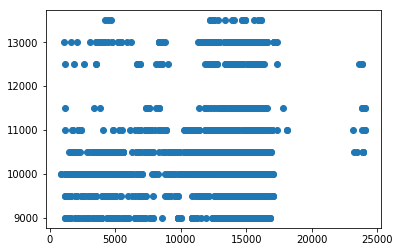

In [80]:
file_list = glob.glob('/lcrc/group/earthscience/rjackson/cloudsat/*.hdf')
new_ctops = []
eth_cpols = []
the_bag = db.from_sequence(file_list)
for the_file in file_list:
    print('Loading ' + the_file)
    new_ctop, eth_cpol = get_eth_cloudsat_and_cpol(the_file)
    if(not np.all(np.isnan(new_ctop)) and not np.all(np.isnan(eth_cpol))):
        new_ctops.append(new_ctop)
        eth_cpols.append(eth_cpol)

new_ctops = np.concatenate(new_ctops)
eth_cpols = np.concatenate(eth_cpols)
plt.scatter(new_ctops, eth_cpols)

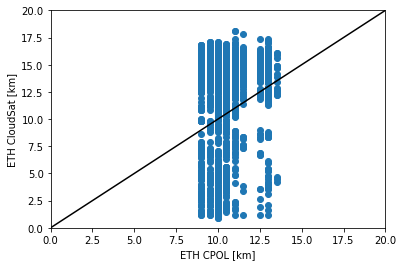

In [83]:
#new_ctops = np.concatenate(new_ctops)
#eth_cpols = np.concatenate(eth_cpols)
plt.scatter(eth_cpols/1e3, new_ctops/1e3)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.xlabel('ETH CPOL [km]')
plt.ylabel('ETH CloudSat [km]')
plt.plot([0, 20], [0, 20], color='k')

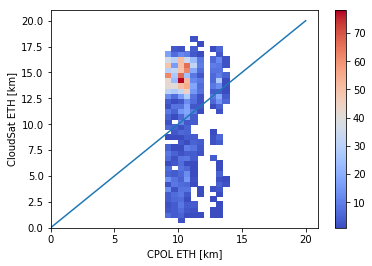

In [84]:
hist, bins_x, bins_y = np.histogram2d(eth_cpols/1e3, new_ctops/1e3, bins=np.arange(0, 20, 0.5))
x, y = np.meshgrid(bins_x, bins_y)
hist[hist == 0] = np.nan
plt.pcolormesh(x,y, hist.T, cmap='coolwarm')
plt.xlabel('CPOL ETH [km]')
plt.ylabel('CloudSat ETH [km]')
plt.colorbar()
plt.plot([0, 20], [0, 20])

In [85]:
print(np.nansum(hist))

2386.0


## VISST to CPOL comparison

In [4]:
import xarray
cdf_data = xarray.open_dataset('/lcrc/group/earthscience/rjackson/visst/twpvisstpx04m1rv4minnisX30.c1.20100629.073000.cdf')
cdf_data

<xarray.Dataset>
Dimensions:                      (index: 17, time: 12146)
Coordinates:
  * time                         (time) datetime64[ns] 2010-06-29T07:30:00 ...
Dimensions without coordinates: index
Data variables:
    base_time                    datetime64[ns] ...
    time_offset                  (time) datetime64[ns] ...
    image_times                  (index) datetime64[ns] ...
    image_start                  (index) float32 ...
    image_numpix                 (index) float32 ...
    latitude                     (time) float32 ...
    longitude                    (time) float32 ...
    reflectance_vis              (time) float32 ...
    reflectance_nir              (time) float32 ...
    temperature_sir              (time) float32 ...
    temperature_ir               (time) float32 ...
    temperature_sw               (time) float32 ...
    broadband_shortwave_albedo   (time) float32 ...
    broadband_longwave_flux      (time) float32 ...
    ir_cloud_emittance           (

In [246]:
cdf_data.cloud_phase[:]

<xarray.DataArray 'cloud_phase' (time: 12146)>
array([3, 6, 1, ..., 4, 4, 4], dtype=int32)
Coordinates:
  * time     (time) datetime64[ns] 2010-06-29T07:30:00 2010-06-29T07:30:00 ...
Attributes:
    valid_min:  0
    valid_max:  7
    long_name:  cloud phase
    units:      unitless
    value_0:    clear over snow/ice
    value_1:    water
    value_2:    ice
    value_3:    no retrieval
    value_4:    clear
    value_5:    bad retrieval
    value_6:    suspected water
    value_7:    suspected ice

In [18]:
import numpy as np
from datetime import datetime
dt = cdf_data.image_times[0].values
ts = (dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
the_dt = datetime.utcfromtimestamp(ts)
the_dt

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.


datetime.datetime(2010, 6, 29, 7, 30)

In [349]:
import xarray


def dt_from_npdt64(npdt64):
    ts = (npdt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    the_dt = datetime.datetime.utcfromtimestamp(ts)
    return the_dt

def get_eth_cpol_and_visst_ctop(file_path):
    print(file_path)
    cdf_data = xarray.open_dataset(file_path)
    
    # Load lat, lon, and time parameters - try statement for 24-hourly data, except for daily data
    try:
        Latitude = cdf_data['latitude'].values
        Longitude = cdf_data['longitude'].values
    except:
        latlonpath = '/lcrc/group/earthscience/rjackson/visst/twpvisstpx04m1rv4minnisX30.c1.20100202.003000.cdf'
        latlond = xarray.open_dataset(latlonpath)
        Latitude = cdf_data['latitude'].values
        Longitude = cdf_data['longitude'].values
        del latlond
        
    Time = cdf_data['image_times'].values
    datetimes = [dt_from_npdt64(x) for x in Time]
    out_datetimes = datetimes.copy()
    NumPixels = cdf_data['image_numpix'].values
    phase = cdf_data['cloud_phase'].values
    

    # Load brightness temperature
    IRBrightness = cdf_data['temperature_ir'].values
    CloudTopHeight = cdf_data['cloud_top_height'].values
    num_frames = len(NumPixels)
    
    echo_top_temps_visst = []
    echo_top_heights_cpol = []
    hours = []
    # For each time, find multidop grid that is within 10 minutes of scan
    for frame in range(0, num_frames):
        the_time = datetimes[frame]
        year = '%4d' % the_time.year
        month = '%02d' % the_time.month
        day = '%02d' % the_time.day
        hour = '%02d' % the_time.hour
        minute = '%02d' % the_time.minute
        
        cpol_eth_file = ('/lcrc/group/earthscience/rjackson/echo_tops/echo_tops_100km_texture5/' + 
                     year + '/' + year + month + day + '/' + 'echo_tops_' + year + month + 
                     day + hour + minute[0] + '0.cdf')
        
        
        # Regrid pixel level data to the CPOL grid
        try:
            echo_top_dset = Dataset(cpol_eth_file)
        except FileNotFoundError as e:
            print('No CPOL file found!')
            out_datetimes.remove(the_time)
            continue
            
        conv_strat_path = ('/lcrc/group/earthscience/rjackson/conv_stratiform/' +
                       year + '/' + month + '/' + day +
                       '/cpol_conv_strat' + year + month + day +
                       hour + minute[0] + '0.nc')
        print(conv_strat_path)
        try:
            data_cdf = Dataset(conv_strat_path)
            conv_strat = data_cdf.variables['strat_conv'][:]
        except:
            conv_strat = np.zeros(shape)
            print(('Cound not find convective-stratiform classification for ' +
                   year_str + '-' + month_str + '-' + day_str + ' ' + hour_str +
                   ':' + minute_str))
            
        lat_echo = echo_top_dset.variables['lat'][:,:]
        lon_echo = echo_top_dset.variables['lon'][:,:]
        eth = echo_top_dset.variables['ETH'][:,:]
        eth[conv_strat < 2] = np.nan
        echo_top_dset.close()
        eth_cpol = eth.flatten()
        # Get brightness temperatures from VISST over same grid
        # Load brightness temperature           
        cpol_latitude = -12.249166
        cpol_longitude = 131.04445
        x = lon_echo
        y = lat_echo
        
        # Get Lat and Lon for specific frame
        Lat = Latitude[(int(frame)*int(NumPixels[frame])):(int(frame+1)*int(NumPixels[frame])-1)]
        Lon = Longitude[(int(frame)*int(NumPixels[frame])):(int(frame+1)*int(NumPixels[frame])-1)]
        data = CloudTopHeight[(int(frame)*int(NumPixels[frame])):(int(frame+1)*int(NumPixels[frame])-1)]
        cloud_phase = phase[(int(frame)*int(NumPixels[frame])):(int(frame+1)*int(NumPixels[frame])-1)]
        not_cloud = np.logical_or.reduce((cloud_phase == 0, cloud_phase == 3, cloud_phase == 5, cloud_phase == 6,
                                              cloud_phase == 7))
        data[not_cloud] = np.nan
        data_gridded = interpolate.griddata((Lon,Lat), data, (x,y))
        lat_gridded = interpolate.griddata((Lon,Lat), Lat, (x,y))
        lon_gridded = interpolate.griddata((Lon,Lat), Lon, (x,y))
        lat_bounds = np.logical_or(lat_gridded > cpol_latitude+1.5,
                                   lat_gridded < cpol_latitude-1.5)
        lon_bounds = np.logical_or(lon_gridded < cpol_longitude-1.5,
                                   lon_gridded > cpol_longitude+1.5)
        masked_region = np.logical_or.reduce((lat_bounds, lon_bounds, np.isnan(data_gridded), data_gridded < 0,
                                              ))
        data_masked = np.ma.array(data_gridded)
        data_masked = np.ma.masked_where(masked_region, data_gridded)
        echo_top_temps_visst.append(data_masked.flatten())
        echo_top_heights_cpol.append(eth_cpol.flatten())
        hours.append(the_time.hour*np.ones(len(eth_cpol)))
    del cdf_data
    try:
        return np.ma.concatenate(echo_top_heights_cpol), np.ma.concatenate(echo_top_temps_visst), np.concatenate(hours)   
    except ValueError as e:
        return np.nan*np.ones(len(out_datetimes)), np.nan*np.ones(len(out_datetimes)), np.nan*np.ones(len(out_datetimes))

In [102]:
cp, visst, dts = get_eth_cpol_and_visst_ctop('/lcrc/group/earthscience/rjackson/visst/twpvisstpx04m1rv4minnisX30.c1.20100202.003000.cdf')

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.


In [104]:
cp = np.concatenate(cp)
visst = np.concatenate(visst)

3000.0


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


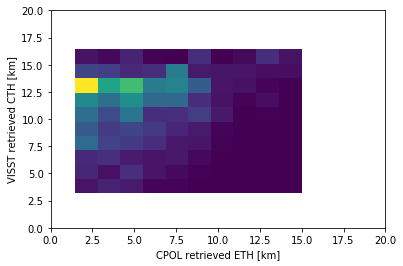

In [111]:
twod_hist, bins_x, bins_y = np.histogram2d(cp[np.logical_and(visst > 3, cp > 1000)]/1e3, 
                                           visst[np.logical_and(visst > 3, cp > 1000)])
plt.pcolormesh(bins_x, bins_y, twod_hist.T)
plt.xlabel('CPOL retrieved ETH [km]')
plt.ylabel('VISST retrieved CTH [km]')
plt.xlim([0,20])
plt.ylim([0,20])
print(np.nanmedian(cp[cp < 25000]))

In [333]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=36, project='rainfall', walltime='2:00:00', 
                       job_cpu=36, memory='128GB')

cluster.scale(4)         # Ask for ten workers

from dask.distributed import Client
client = Client(cluster)  # Connect this local process to remote workers

# wait for jobs to arrive, depending on the queue, this may take some time

import dask.array as da

In [335]:
client

Client Scheduler: tcp://140.221.70.6:32814 Dashboard: http://140.221.70.6:45028/status,Cluster Workers: 4 Cores: 144 Memory: 512.00 GB


In [350]:
file_list = glob.glob('/lcrc/group/earthscience/rjackson/visst/twpvisstpx04m1rv4minnisX30.c1*.cdf')
print(str(len(file_list)) + " files to process")
bag = db.from_sequence(file_list)

%time statistics = bag.map(get_eth_cpol_and_visst_ctop).compute()

1102 files to process
CPU times: user 29 s, sys: 14.4 s, total: 43.4 s
Wall time: 1min 56s


In [332]:
cluster.stop_all_jobs()

In [351]:
cpol = np.concatenate([x[0] for x in statistics])
visst = np.concatenate([x[1] for x in statistics])
hours = np.concatenate([x[2] for x in statistics])

In [329]:
print(hours.shape)

(112920795,)


In [352]:
cpol_daytime = np.ma.masked_where(np.logical_or(hours < 9, hours > 22), cpol)
cpol_nottwilight =  np.ma.masked_where(np.logical_and(~np.logical_and(hours >= 7, hours <= 11),
                                                      ~np.logical_and(hours >= 20, hours <= 24)), cpol)

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-pack

3000.0
[[ 4.025  4.25   4.475]
 [ 3.525  4.75   6.45 ]
 [ 3.     5.5    7.5  ]
 [ 3.     5.5    9.5  ]
 [ 3.5    5.5   11.   ]
 [ 3.5    5.5   10.5  ]
 [ 3.5    6.     9.5  ]
 [ 3.5    5.5   10.5  ]
 [ 3.5    5.5   10.   ]
 [ 3.5    6.5   10.   ]
 [ 3.5    6.    10.5  ]
 [ 4.     6.5   10.5  ]
 [ 4.     7.    11.   ]
 [ 4.     7.    11.5  ]
 [ 4.     7.    12.5  ]
 [ 3.5    7.    12.   ]
 [ 4.     7.    12.   ]
 [ 4.     7.    11.5  ]
 [ 4.     7.5   11.5  ]
 [ 4.     7.    11.5  ]
 [ 4.275  7.5   12.   ]
 [ 4.5    7.5   12.   ]
 [ 4.     8.    12.5  ]
 [ 4.     8.    13.   ]
 [ 4.     8.5   13.   ]
 [ 4.     8.5   13.5  ]
 [ 4.     9.    14.   ]
 [ 4.5    9.5   14.   ]
 [ 4.5   10.    14.5  ]
 [ 4.5   10.5   15.   ]
 [ 5.    11.    15.   ]
 [ 5.    11.5   15.5  ]
 [ 5.    12.    16.   ]
 [   nan    nan    nan]
 [   nan    nan    nan]
 [   nan    nan    nan]
 [   nan    nan    nan]
 [   nan    nan    nan]
 [   nan    nan    nan]]


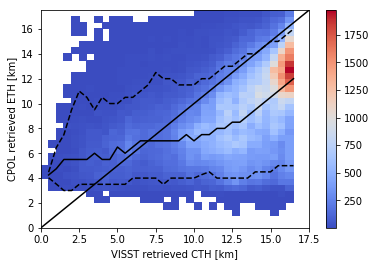

In [353]:
avg_bins = np.arange(0, 20, 0.5)
quartiles_x = np.nan*np.zeros((len(avg_bins)-1,3))
quartiles_y = np.nan*np.zeros((len(avg_bins)-1,3))
array2 = cpol_nottwilight[np.logical_and(visst > 0, visst < 16.5)]/1e3
array1 = visst[np.logical_and(visst > 0, visst < 16.5)]
for i in range(0, 33):
    x_restrictions = np.logical_and.reduce((array1 >= avg_bins[i],
                                            array1 < avg_bins[i+1],
                                            array2.mask == False))
    y_restrictions = np.logical_and.reduce((array2 >= avg_bins[i],
                                            array2 < avg_bins[i+1],
                                            array2.mask == False))
    try:
        quartiles_y[i,:] = np.nanpercentile(array2[x_restrictions],
                                            [5, 50, 95])
        quartiles_x[i,:] = np.nanpercentile(array1[y_restrictions],
                                            [5, 50, 95])
    except:
        continue

        
twod_hist, bins_x, bins_y = np.histogram2d(array1, array2, avg_bins)
twod_hist[twod_hist == 0] = np.nan
plt.pcolormesh(bins_x, bins_y, twod_hist.T, cmap='coolwarm')
plt.plot(bins_x[1:], quartiles_y[:,0], color='k', linestyle='--')
plt.plot(bins_x[1:], quartiles_y[:,1], color='k')
plt.plot(bins_x[1:], quartiles_y[:,2], color='k', linestyle='--')
plt.ylabel('CPOL retrieved ETH [km]')
plt.xlabel('VISST retrieved CTH [km]')
plt.xlim([0,17.5])
plt.ylim([0,17.5])
plt.plot([0, 20], [0, 20], color='k')
plt.colorbar()
print(np.nanmedian(cp[cp < 25000]))
print(quartiles_y)